## Generic scripts to process data

## Download data

Data was selected by going onto SRA and searching for bacteria (on 03 July 2022): https://www.ncbi.nlm.nih.gov/sra/?term=bacteria
with the following filters:

1. Source: RNA (92). 
2. Platform: Oxford Nanopore (92). 
3. File Type: fastq (92). 

Then clicking: Send Results To Run Selector 

This took me to: https://www.ncbi.nlm.nih.gov/Traces/study/?query_key=55&WebEnv=MCID_62c11a8cfa53570d29c0bbe7&f=assay_type_s%3An%3Arna-seq%3Ac&o=assay_type_s%3Aa&s=SRR13212615,SRR13212616,SRR13212618,SRR13212623,SRR13212624,SRR13212626,SRR13212627,SRR13212631,SRR13212634,SRR13212637,SRR13212639,SRR13212614,SRR13212617,SRR13212619,SRR13212620,SRR13212622,SRR13212625,SRR13212628,SRR13212629,SRR13212630,SRR13212632,SRR13212633,SRR13212635,SRR13212636,SRR13212638,SRR17704197,SRR17704198,SRR17704200,SRR18061003,SRR18061004,SRR7719052,SRR7719053,SRR7719054,SRR7719055,ERR3327116,ERR3327117,ERR3327118,ERR3327115,ERR3327119,ERR3327114,SRR9733840,SRR9733842,SRR17704196,SRR17704199,SRR17704201,SRR12090426,SRR12090427,SRR12090428,SRR12090429,SRR12090430,SRR12090431,SRR12090432,SRR12090433,SRR12090434,SRR12090435,SRR16009459,SRR16009460,SRR16009461,SRR16009462,SRR16009463,ERR9606777,ERR9606779,ERR9606780,ERR9606554,SRR17774983,SRR17774984,SRR17774985,SRR17774986,SRR17774987,SRR17774988,SRR17774989,SRR17774990,SRR17774991,SRR17774992,SRR17774993,SRR17774994,SRR18061002,SRR18061005,SRR18432816,SRR18432817,SRR16608235,SRR16608236,SRR16608237,SRR16608238

Where I realised that there were some ncrna-seq, and some wgs sequences, these were filtered leaving 84 files (84	43.50 Gb	51.59 G)

I downloaded the metadata and accession list. To look at downloading a file, I clicked on one of the Runs, and then went to the **Data access** tab, here I saw that you can download from AWS, by using the link: https://sra-pub-run-odp.s3.amazonaws.com/sra/SRR13212615/SRR13212615 which seems to be in the format of link, followed by the accession/accession so I thought I'd try that rather than having to download each :) 

In [8]:
import pandas as pd
data = '../data/'
meta = pd.read_csv(f'{data}SraRunTable_RNAseq_bacteria_oxfordnanopore.csv')
accs = meta['Run'].values
links = [f'https://sra-pub-run-odp.s3.amazonaws.com/sra/{acc}/{acc}' for acc in accs]
# Now we can try download each of these, do do this just save as a file then we 
# can wget them (try 1)
#import os
#os.system(f'wget {links[0]}') # Seemed to work but it was a GB and I have no space left 
# anyway, let's save the links to a text file then run this on the HPC
with open(f'{data}SRA_bacteria_oxfordnanopore_links.txt', 'w+') as f:
    for l in links:
        f.write(f'{l}\n')
        
# Go somewhere and write: wget -i SRA_bacteria_oxfordnanopore_links.txt 
# they should now download one at a time (I'm not in a rush so works easy)

### Next Step

The next thing we want to do is run Eligos on each of the fastq files to see if there are any RNA modifications. 

To do this we need to map the reads to a genome, so we need to get the genome for each of the fastq files. We also will need a bed file with the genes for each genome.
    
1. Get transcriptome for each species
2. Convert transcriptome into bed file (since that is what eligos needs as input)



In [10]:
meta['Organism'].value_counts()  # Cool we don't have that many 

Listeria monocytogenes                  29
Escherichia coli                        14
Streptococcus mutans                    12
Xylella fastidiosa subsp. fastidiosa    11
Pseudomonas aeruginosa UCBPP-PA14        6
Vibrio parahaemolyticus                  4
Klebsiella pneumoniae                    4
Pandoraea fibrosis                       2
Staphylococcus aureus                    2
Name: Organism, dtype: int64

In [11]:
# For each organism let's have a look at if there are multiple strains and if
# we can actually find the genome for it...
from sciutil import SciUtil
u = SciUtil()

for organism in list(set(meta['Organism'].values)):
    org = meta[meta['Organism'] == organism]
    u.dp([organism])
    print(org['strain'].value_counts())
    
https://www.ebi.ac.uk/ena/browser/view/SRR17774988

--------------------------------------------------------------------------------
                     Xylella fastidiosa subsp. fastidiosa	                      
--------------------------------------------------------------------------------
Stag's Leap    11
Name: strain, dtype: int64
--------------------------------------------------------------------------------
                             Klebsiella pneumoniae	                             
--------------------------------------------------------------------------------
20_GR_12    1
1_GR_13     1
16_GR_13    1
2_GR_12     1
Name: strain, dtype: int64
--------------------------------------------------------------------------------
                             Streptococcus mutans	                              
--------------------------------------------------------------------------------
B04Sm5         4
B04Sm5-mucH    4
B04Sm5-mucG    4
Name: strain, dtype: int64
-----------------------------------------------------------------

## Data

Guess there are a few so let's see if I can find these on NCBI 
looked https://www.ncbi.nlm.nih.gov/assembly/?term=klebsiella+pneumoniae%5Borgn%5D++20_GR_12
and searcher for the name plus the strain

From download, selected RefSeq and downloaded the gff, genome, and CDS
https://www.ncbi.nlm.nih.gov/genome/?term=Klebsiella+pneumoniae
Went to the reference genome, and selected the Chr then clicked on assembly and downloaded that for each

|Name|link|
|:----|:----|
|Klebsiellapneumoniae-20_GR_12| https://www.ncbi.nlm.nih.gov/assembly/GCF_001701845.2|
|Klebsiellapneumoniae-1_GR_13|  https://www.ncbi.nlm.nih.gov/assembly/GCF_001701425.2|
|Klebsiellapneumoniae-16_GR_13|    https://www.ncbi.nlm.nih.gov/assembly/GCF_001701835.2|
|Klebsiellapneumoniae-2_GR_12| https://www.ncbi.nlm.nih.gov/assembly/GCF_001702045.2|
|Xylellafastidiosa-stags_leap| https://www.ncbi.nlm.nih.gov/assembly/GCF_021459925.1|
|Streptococcusmutans-B04Sm5| https://www.ncbi.nlm.nih.gov/assembly/GCF_014621675.1|  No results were found for the others|
|Vibrioparahaemolyticus-RIMD_2210633| https://www.ncbi.nlm.nih.gov/assembly/GCF_000196095.1/|
|Listeriamonocytogenes-ref| https://www.ncbi.nlm.nih.gov/assembly/GCF_000196035.1 |used the reference since the strains didn't seem specific|
|Staphylococcusaureus-USA300| https://www.ncbi.nlm.nih.gov/assembly/GCF_022226995.1    | there were three| so I selected complete genomePandoraeafibrosis-6399| https://www.ncbi.nlm.nih.gov/assembly/GCF_000807775.2Pandoraeafibrosis-7641| https://www.ncbi.nlm.nih.gov/assembly/GCF_000807785.2|
|Escherichiacoli-K_12|   https://www.ncbi.nlm.nih.gov/assembly/GCF_000005845.2| downloaded the reference for escherichia coli k-12[orgn]Escherichiacoli-E2348_69|    https://www.ncbi.nlm.nih.gov/assembly/GCF_000026545.1|
|Pseudomonasaeruginosa-UCBPP_PA14| https://www.ncbi.nlm.nih.gov/assembly/GCF_000014625.1|


Data are now in SRA format, so we need to convert them back to the fastq format
https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit
https://github.com/ncbi/sra-tools
downloaded version 3.0 sratoolkit.3.0.0-ubuntu64.tar.gz for linux and unziped (`tar -xvzf  sratoolkit.3.0.0-ubuntu64.tar.gz`)

Added the sra toolkit bin to my path:

`export PATH=" full path to sratoolkit.3.0.0-ubuntu64/bin:$PATH"`

Then you can run: `fastq-dump --gzip {filename}` for each of the accessions.


Hmmm looking at the data they have 't' rather than 'U' so look to see if the non-coding versions do too...
https://www.ebi.ac.uk/ena/browser/view/SRR14498249


In [ ]:
# Make a little script to convert each file for us
import os
files = os.listdir('.')
for f in files:
    os.system(f'mv {f} {f}.sra')
    os.system(f'fastq-dump --gzip {f}.sra')

## Generic genome distances

First, let's use FastANI and FastTree to get the placement of the genomes. 

We're interested in looking at whether, if we just looked at RNA modifications, the distances are the same.

Download fastANI: 
```
wget https://github.com/ParBLiSS/FastANI/releases/download/v1.33/fastANI-Linux64-v1.33.zip
unzip fastANI-Linux64-v1.33.zip
```
Based on the documentation (https://github.com/ParBLiSS/FastANI), we want to do a many to many query:
```
$ ./fastANI --ql [QUERY_LIST] --rl [REFERENCE_LIST] -o [OUTPUT_FILE]
```
Example usage:
```
$ fastANI -q genome1.fa -r genome2.fa -o output.txt
$ fastANI -q genome1.fa --rl genome_list.txt -o output.txt
```


In [7]:
# First get fastANI running, using the genomes in the genome dir
import os
working_dir = '/media/WorkingSpace/Ariane/output/bacteria/'
output_folder = f'{working_dir}runs/'
fastq_dir = f'{working_dir}data_fastq/bacteria/'
genome_dir = f'{working_dir}genomes/'
query_list = [g for g in os.listdir(genome_dir) if 'fna' in g and '.fai' not in g]
with open(f'{working_dir}query.txt', 'w+') as q:
    with open(f'{working_dir}ref.txt', 'w+') as r:
        for query in query_list:
            q.write(f'{genome_dir}{query}\n')
            r.write(f'{genome_dir}{query}\n')
print(f'/media/WorkingSpace/Ariane/output/bacteria/software/./fastANI -t 20 --ql {working_dir}query.txt --rl {working_dir}ref.txt -o {working_dir}FastANI.csv')

/media/WorkingSpace/Ariane/output/bacteria/software/./fastANI -t 20 --ql /media/WorkingSpace/Ariane/output/bacteria/query.txt --rl /media/WorkingSpace/Ariane/output/bacteria/ref.txt -o /media/WorkingSpace/Ariane/output/bacteria/FastANI.csv


In [64]:
! pip install sciutil

  Using cached sciutil-1.0.3-py3-none-any.whl (34 kB)


In [68]:
## Have a look in each gff at which genes are shared between the species/strains that we have
query_list = [g for g in os.listdir(genome_dir) if 'gff' in g and 'genomic' in g]
from sciutil import SciUtil

u = SciUtil()
for gff_file in query_list:
    rows = []
    f_name = gff_file.replace('_genomic.gff', '')
    u.dp([f_name])
    with open(f'{genome_dir}{gff_file}', 'r') as gff:
        for line in gff:
            if line[0] == '#':
                continue
            else:
                line = line.split('\t')
                line[-1] = line[-1].strip()
                rows.append([f'{line[0]}:{line[3]}-{line[4]}'] + line)
    gff_df = pd.DataFrame(rows)
    # This is indeed the case!!!! OMG how annoying cmon
    print(len(df), len(set(gff_df[0].values)))

    df = gff_df[gff_df[2] == 'RefSeq']
    print(len(df), len(set(df[0].values))) # Still got dups
    print(df[3].value_counts())
    # OK so let's just keep the genes and the tRNA, rRNA, and ncRNAs
    df = df[df[3].isin(['gene', 'tRNA', 'ncRNA', 'rRNA'])]
    print(len(df), len(set(df[0].values))) # Still got dups
    # Sort by '3' and drop duplicates
    df = df.sort_values(by=[0, 3])
    #print(df[df.duplicated([0], keep=False)].sort_values(by=[0]).head()) # Can see that it is mainly the genes/trnas
    df = df.drop_duplicates(subset=[0], keep='last')
    print(len(df), len(set(df[0].values))) # Still got dups
    #print(df[3].value_counts()) # Can see that it is mainly the genes/trnas
    # Save to tsv without the header and also drop that first column (i.e. save rows 1 - 9)
    df = df.drop(columns=[0])
    df.to_csv(f'{genome_dir}{gff_file.replace("genomic", "genes-RNA")}', sep='\t', index=False, header=False)

--------------------------------------------------------------------------------
                           GCF_000026545.1_ASM2654v1	                           
--------------------------------------------------------------------------------
3049 5137
5104 5104
gene          4824
pseudogene     277
region           3
Name: 3, dtype: int64
4824 4824
4824 4824
--------------------------------------------------------------------------------
                          GCF_000807785.2_ASM80778v2	                           
--------------------------------------------------------------------------------
4824 4961
4950 4950
gene          4875
pseudogene      74
region           1
Name: 3, dtype: int64
4875 4875
4875 4875
--------------------------------------------------------------------------------
                           GCF_000005845.2_ASM584v2	                            
--------------------------------------------------------------------------------
4875 4754
9490 4754
gene         

In [ ]:
import sys
sys.path.append('/media/WorkingSpace/Ariane/output/rnamod/TomboRunner/')
sys.path.append('/media/WorkingSpace/Ariane/output/rnamod/TomboRunner/ModRunner/')                            
import pandas as pd
from ModRunner import *
done_runs = []
working_dir = '/media/WorkingSpace/Ariane/output/bacteria/'
output_folder = f'{working_dir}runs/'
runs = os.listdir(f'{output_folder}')
runs = [r for r in runs if 'csv' in r and r not in done_runs]
debug = False
threads = 20
for run in runs:
    run = run.replace('.csv', '')
    data_file = f'{output_folder}{run}.csv'
    logfile = f'{output_folder}{run}_logfile.txt'
    wt_sample = run
    # 1. Setup transcriptome and bam files with minimap2
    #runner = Minimap2Runner(data_file, debug=debug, logging_file=logfile)
    #runner.gff_to_bed(filter_value=None)
    #runner.genome_to_transcripts()
    print(run, runner.get_reference_path(run))
    #runner.fasta_to_bam()
#     runner.fasta_to_bam(genome=True) # Do this for eligos2 later on (skip if not doing eligos2)
    #runner.gff_to_bed(filter_value='gene')
    # 5. Eligos2 NO IVT comparison for WT only
    runner = EligosRunner(data_file, debug=debug, logging_file=logfile)
    runner.test_against_model_ts(wt_sample)
    break

## Now we need to do the transcriptome and make bam files using these

In [69]:
## Have a look in each gff at which genes are shared between the species/strains that we have
query_list = [g for g in os.listdir(genome_dir) if 'gff' in g and 'genes-RNA' in g]
rows = []
filter_value = 'gene'
for gff_file in query_list:
    f_name = gff_file.replace('_genomic.gff', '')
    with open(f'{genome_dir}{gff_file}', 'r') as gff:
        for line in gff:
            if line[0] == '#':
                continue
            else:
                line = line.split('\t')
                if filter_value is not None:
                    if filter_value == line[2]:  # i.e. make sure that the line contains something of interest e.g. gene
                        name = line[-1].strip()
                        # Dbxref, ID, Name, GeneID # Each could be separated by a comma
                        cols = ['ID', 'Name', 'GeneID', 'Dbxref', 'locus_tag', 'gene', 'gene_biotype']
                        name = name.split(';')
                        row = [f_name, line[0], line[3], line[4], line[6]] # source, chr, start, end, strand 
                        for c in cols:
                            found = False
                            for n in name:
                                n = n.split('=')
                                if n[0] == c:
                                    row.append(n[1])
                                    found = True
                                    break
                            if not found:
                                row.append(None)
                        rows.append(row)

In [70]:
import pandas as pd
df = pd.DataFrame(data=rows, columns=['Source', 'chr', 'start', 'end', 'strand', 'ID', 'Name', 'GeneID', 'Dbxref', 'locus_tag', 'gene', 'gene_biotype'])
df.Name.value_counts()

rrf               82
lpdA              24
fabG              24
asd               22
fusA              22
                  ..
VP_RS16255         1
lmo0646            1
VP_RS23440         1
VP_RS21720         1
AH5667_RS00490     1
Name: Name, Length: 42640, dtype: int64

In [71]:
assemblys = set([g.replace('_genomic.gff', '') for g in query_list])
assemblys

{'GCF_000005845.2_ASM584v2_genes-RNA.gff',
 'GCF_000014625.1_ASM1462v1_genes-RNA.gff',
 'GCF_000026545.1_ASM2654v1_genes-RNA.gff',
 'GCF_000196035.1_ASM19603v1_genes-RNA.gff',
 'GCF_000196095.1_ASM19609v1_genes-RNA.gff',
 'GCF_000807775.2_ASM80777v2_genes-RNA.gff',
 'GCF_000807785.2_ASM80778v2_genes-RNA.gff',
 'GCF_001701425.2_ASM170142v2_genes-RNA.gff',
 'GCF_001701835.2_ASM170183v2_genes-RNA.gff',
 'GCF_001701845.2_ASM170184v2_genes-RNA.gff',
 'GCF_001702045.2_ASM170204v2_genes-RNA.gff',
 'GCF_014621675.1_ASM1462167v1_genes-RNA.gff',
 'GCF_021459925.1_ASM2145992v1_genes-RNA.gff',
 'GCF_022226995.1_ASM2222699v1_genes-RNA.gff'}

In [72]:
# Collect the genes that exist in every one of the genomes!
df_grped = df.groupby('Name')
genes_in_all = []
for d in df_grped:
    gene_name = d[0]
    sources = list(d[1]['Source'].values)
    if len(set(sources) & assemblys) == len(assemblys):
        genes_in_all.append(gene_name)

print(len(genes_in_all), "had counts >= 14 (the number of gff files)")
common_df = df[df.Name.isin(genes_in_all)]
common_df = common_df.sort_values(by='Name')
common_df

199 had counts >= 14 (the number of gff files)


,Source,chr,start,end,strand,ID,Name,GeneID,Dbxref,locus_tag,gene,gene_biotype
58408,GCF_001701835.2_ASM170183v2_genes-RNA.gff,NZ_CP027036.1,5066071,5066991,-,gene-A6D82_RS25385,accD,None,None,A6D82_RS25385,accD,protein_coding
61826,GCF_021459925.1_ASM2145992v1_genes-RNA.gff,NZ_CP090518.1,849816,850712,+,gene-LZ752_RS03645,accD,None,None,LZ752_RS03645,accD,protein_coding
31782,GCF_022226995.1_ASM2222699v1_genes-RNA.gff,NZ_CP092052.1,1740276,1741133,-,gene-AH5667_RS08480,accD,None,None,AH5667_RS08480,accD,protein_coding
15970,GCF_000005845.2_ASM584v2_genes-RNA.gff,NC_000913.3,2433012,2433926,-,gene-b2316,accD,None,"ASAP:ABE-0007648,ECOCYC:EG10217,GeneID:946796",b2316,accD,protein_coding
704,GCF_000196035.1_ASM19603v1_genes-RNA.gff,NC_003210.1,1612395,1613279,-,gene-lmo1573,accD,None,GeneID:986998,lmo1573,accD,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...
3265,GCF_000014625.1_ASM1462v1_genes-RNA.gff,NC_008463.1,1289880,1291259,-,gene-PA14_RS06065,xseA,None,None,PA14_RS06065,xseA,protein_coding
22675,GCF_000026545.1_ASM2654v1_genes-RNA.gff,NC_011601.1,2855806,2857179,+,gene-E2348C_RS14910,xseA,None,None,E2348C_RS14910,xseA,protein_coding
31595,GCF_022226995.1_ASM2222699v1_genes-RNA.gff,NZ_CP092052.1,1571498,1572835,-,gene-AH5667_RS07620,xseA,None,None,AH5667_RS07620,xseA,protein_coding
9245,GCF_001701425.2_ASM170142v2_genes-RNA.gff,NZ_CP027042.1,1310265,1311656,-,gene-A6D67_RS06605,xseA,None,None,A6D67_RS06605,xseA,protein_coding


In [73]:
common_df.to_csv(f'../output/shared_genes_in_assemblies.csv', index=False)

In [74]:
genes = list(set([n for n in common_df.Name.values]))

### Check what these gene's do

Since there are 200 genes, let's look if they're all involved in certain things

To do this, we need the GO terms associated with the shared genes, we can get these from GO:
http://current.geneontology.org/products/pages/downloads.html
Downloaded the Multi-species
Encyclopedia of E. coli metabolism (ecocyc)	n/a	55232	ecocyc.gaf (gzip)
There are others available at: https://ecocyc.org/links.shtml
http://bioinformatics.ai.sri.com/ptools/flatfile-format.html#Attribute-Value 

Went to reactome and downloaded the pathways associated with ecoli and Listeria
https://reactome.org/content/schema/objects/Species?page=2

https://reactome.org/content/schema/instance/browser/8875362


In [75]:
# Format the gene file so we can use it in ORA/GSEA
#gene,term
#AKT3,GO_MITOCHONDRIAL_GENOME_MAINTENANCE
gene_go = []
gene_rows = []
with open(f'../supps/ecocyc.gaf', 'r') as f:
    for line in f:
        if line[0] != '#' and line[0] != '!':
            line = line.split('\t') # gene = line[2], go = line[4]
            gene_go.append([line[2], line[4]])
            gene_rows.append(line)
gene_go_df = pd.DataFrame(gene_go, columns=['gene', 'term'])
gene_go_df.to_csv(f'../supps/ecocyc.csv', index=False)
gene_go_df

,gene,term
0,ftsK,GO:0005886
1,minD,GO:0005886
2,mutM,GO:0004519
3,caiB,GO:0008735
4,caiB,GO:0008735
...,...,...
61096,qseB,GO:0005829
61097,rpiA,GO:0006014
61098,opgH,GO:0016758
61099,rarA,GO:0008047


In [76]:
all_go_df = pd.DataFrame(gene_rows, columns = ['UniprotID', 'ID', 'gene', 'Term thing', 'GO', 'PMID', 'Acc', 'Long', 'L', 'Label', 'genes', 'Type', 'Taxon', 'taxID', 'Source', 'NA', 'NA'])

In [77]:
term_to_label = dict(zip(all_go_df.GO, all_go_df.Label))

In [78]:
## Unfortunatly, ORA seems annoying to use with non-model organismis
## So I'll just do a fischers exact test for ORA and see what GO terms we come up with
import numpy as np
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
columns = ['GO', 'p-value', 'odds-ratio',
           'genes with GO and in cluster',
           'genes in cluster but not GO',
           'genes in GO but not cluster',
           'genes not in GO or cluster',
           'gene_names']
rows = []
gene_id = 'sequence_name'
bg_genes = list(set(df['Name'].values))
cluster_genes = genes
bg_genes = [g for g in bg_genes if g not in genes]
gene_id = 'gene'
for go in gene_go_df['term'].unique():
    go_df = gene_go_df[gene_go_df['term'] == go]
    go_enriched_genes = go_df[gene_id].values
    cont_table = np.zeros((2, 2))  # Rows=ct, not ct; Cols=Module, not Module
    if len(go_enriched_genes) > 0:  # Some DE genes
        in_go_and_cluster = len(set(cluster_genes) & set(go_enriched_genes))
        cluster_not_go = len(cluster_genes) - in_go_and_cluster
        go_not_cluster = len(go_enriched_genes) - in_go_and_cluster
        if in_go_and_cluster > 2:  # Require there to be at least 3 genes overlapping
            not_go_not_cluster = len(bg_genes) - (in_go_and_cluster + cluster_not_go + go_not_cluster)
            # Populating cont table
            cont_table[0, 0] = in_go_and_cluster
            cont_table[1, 0] = cluster_not_go
            cont_table[0, 1] = go_not_cluster
            cont_table[1, 1] = not_go_not_cluster
            # Doing FET, Enrichment IN GO only.
            odds_ratio, pval = fisher_exact(cont_table, alternative="greater")
            genes_ids = list(set(cluster_genes) & set(go_enriched_genes))
            rows.append([go, pval, odds_ratio, in_go_and_cluster,
                         cluster_not_go, go_not_cluster, not_go_not_cluster,
                         ' '.join(genes_ids)])
odds_ratio_df = pd.DataFrame(data=rows, columns=columns)
reg, padj, a, b = multipletests(odds_ratio_df['p-value'].values,
                                alpha=0.05, method='fdr_bh', returnsorted=False)
odds_ratio_df['p.adj'] = padj

In [79]:
## For each gene pull out the sequence from the transcriptome file for each of our references
odds_ratio_df['Label'] = [term_to_label.get(g) for g in odds_ratio_df['GO'].values]
odds_ratio_df

,GO,p-value,odds-ratio,genes with GO and in cluster,genes in cluster but not GO,genes in GO but not cluster,genes not in GO or cluster,gene_names,p.adj,Label
0,GO:0005886,7.967542e-01,0.839322,19,180,4719,37523,ftsL lepA atpA secE mraY dnaK dnaA lspA parC f...,7.967542e-01,
1,GO:0004519,3.582028e-03,10.413101,3,196,62,42180,mutM rpsP rnpA,3.890415e-03,ribonuclease HI
2,GO:0051301,4.806755e-08,13.945197,9,190,143,42099,ftsL ftsZ tig murC mraY murD clpX ftsA murA,1.313846e-07,cell division protein FtsA
3,GO:0005829,9.317138e-149,60.580239,144,55,1750,40492,rpsT ruvB rplE gyrA rpsM rpmF rbfA nusB rpsG s...,1.528011e-146,DNA-binding transcriptional activator QseB
4,GO:0006351,4.905499e-03,4.770312,5,194,227,42015,rpoB gyrB rpoZ rpoC gyrA,5.258182e-03,DNA-binding transcriptional dual regulator GcvA
...,...,...,...,...,...,...,...,...,...,...
159,GO:0005694,5.588752e-06,129.296939,3,196,5,42237,gyrB parC gyrA,9.750589e-06,ATP-dependent DNA helicase RecQ
160,GO:0006754,8.354121e-06,107.744898,3,196,6,42236,atpB atpA atpD,1.398037e-05,ATP synthase F1 complex subunit epsilon
161,GO:0009058,1.026262e-07,31.236121,6,193,42,42200,murC coaD murD fmt hisC purN,2.475102e-07,isochorismate synthase EntC
162,GO:0003899,2.636713e-06,50.950226,4,195,17,42225,rpoB rpoZ rpoC dnaG,4.970355e-06,RNA polymerase subunit beta


In [80]:
# Let's just look at the top 
odds_ratio_df.to_csv(f'../output/GO_odds_ratio.csv', index=False)

In [243]:
import pandas as pd
run_to_ass = pd.read_csv(f'../output/run_to_assembly.csv')
run_to_ass

,Run,SampleName,Species,Strain,Name,AssemblyID
0,SRR13212615,01_Listeria_RNA_seq,Listeria,NaN,Listeriamonocytogenes-ref,GCF_000196035.1
1,SRR13212616,01_Listeria_RNA_seq,Listeria,NaN,Listeriamonocytogenes-ref,GCF_000196035.1
2,SRR13212618,01_Listeria_RNA_seq,Listeria,NaN,Listeriamonocytogenes-ref,GCF_000196035.1
3,SRR13212623,01_Listeria_RNA_seq,Listeria,NaN,Listeriamonocytogenes-ref,GCF_000196035.1
4,SRR13212624,01_Listeria_RNA_seq,Listeria,NaN,Listeriamonocytogenes-ref,GCF_000196035.1
...,...,...,...,...,...,...
79,SRR16608236,Bile1,Vibrio,RIMD,Vibrioparahaemolyticus-RIMD_2210633,GCF_000196095.1
80,SRR16608237,LB2,Vibrio,RIMD,Vibrioparahaemolyticus-RIMD_2210633,GCF_000196095.1
81,SRR16608238,LB1,Vibrio,RIMD,Vibrioparahaemolyticus-RIMD_2210633,GCF_000196095.1
82,SRR18432816,GSM5965598,Staphylococcus,USA300,Staphylococcusaureus-USA300,GCF_022226995.1


In [244]:
ass_to_name = dict(zip(run_to_ass.AssemblyID, run_to_ass.Name))
len(ass_to_name)

14

In [245]:
ass_to_name

{'GCF_000196035.1': 'Listeriamonocytogenes-ref',
 'GCF_021459925.1': 'Xylellafastidiosa-stags_leap',
 'GCF_000026545.1': 'Escherichiacoli-E2348_69',
 'GCF_001701835.2': 'Klebsiellapneumoniae-16_GR_13',
 'GCF_001701845.2': 'Klebsiellapneumoniae-20_GR_12',
 'GCF_001701425.2': 'Klebsiellapneumoniae-1_GR_13',
 'GCF_001702045.2': 'Klebsiellapneumoniae-2_GR_12',
 'GCF_000014625.1': 'Pseudomonasaeruginosa-UCBPP_PA14',
 'GCF_000807775.2': 'Pandoraeafibrosis-6399',
 'GCF_000807785.2': 'Pandoraeafibrosis-7641',
 'GCF_000005845.2': 'Escherichiacoli-K_12',
 'GCF_014621675.1': 'Streptococcusmutans-B04Sm5',
 'GCF_000196095.1': 'Vibrioparahaemolyticus-RIMD_2210633',
 'GCF_022226995.1': 'Staphylococcusaureus-USA300'}

In [246]:
refs_dir = '../data_refs/'
meta = pd.read_csv(f'{refs_dir}SraRunTable_RNAseq_bacteria_oxfordnanopore.csv')
meta

,Run,Assay Type,AvgSpotLen,Bases,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,...,tissue,geographic_location_(country_and/or_sea),host_health_state,host_scientific_name,Host_disease,BIOMATERIAL_PROVIDER,media,Note,treatment,type-material
0,SRR13212615,RNA-Seq,1096,1522106869,SAMN17023022,1454555653,"NEW ENGLAND BIOLABS, INC",public,"fastq,sra","s3,ncbi,gs",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SRR13212616,RNA-Seq,979,701284083,SAMN17023022,674896977,"NEW ENGLAND BIOLABS, INC",public,"sra,fastq","ncbi,s3,gs",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SRR13212618,RNA-Seq,717,137491381,SAMN17023022,135168447,"NEW ENGLAND BIOLABS, INC",public,"fastq,sra","gs,ncbi,s3",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SRR13212623,RNA-Seq,1096,1522106774,SAMN17023022,1454222338,"NEW ENGLAND BIOLABS, INC",public,"fastq,sra","ncbi,gs,s3",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SRR13212624,RNA-Seq,979,701284088,SAMN17023022,674731029,"NEW ENGLAND BIOLABS, INC",public,"fastq,sra","ncbi,s3,gs",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,SRR16608236,RNA-Seq,822,851534610,SAMN22630217,626320528,OSAKA UNIVERSTIY,public,"fastq,sra","ncbi,s3,gs",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,SRR16608237,RNA-Seq,879,1002194957,SAMN22630216,732648027,OSAKA UNIVERSTIY,public,"fastq,sra","ncbi,gs,s3",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,SRR16608238,RNA-Seq,873,1519514091,SAMN22630215,1107523038,OSAKA UNIVERSTIY,public,"fastq,sra","ncbi,s3,gs",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,SRR18432816,RNA-Seq,380,840405187,SAMN26871989,709489358,GEO,public,"fastq,sra","ncbi,gs,s3",...,NaN,NaN,NaN,NaN,NaN,NaN,TSB,NaN,Sample harvested at OD600 = 3 after growth in TSB,NaN


In [247]:
import pysam
import re, os, sys
def filter_reads(reads, min_mapq=0):
#     reads = [read for read in reads if not read.alignment.is_supplementary and not read.alignment.is_unmapped and not read.alignment.is_duplicate and not read.is_refskip]
#     if min_mapq > 0:
#         reads = [read for read in reads if read.alignment.mapq >= min_mapq]
    return reads

def divided(x, y):
    if x == 0 or y == 0:
        return float(0)
    else:
        return float(x)/float(y)

    
##### Decision modules
def rvStrand(reverse, is_reverse, bam_type=None):
    if bam_type == 'cdna':
        return True
    elif   reverse == True  and is_reverse:
        return True
    elif reverse == False and not is_reverse:
        return True
    else:
        return False
    
bam_type = None

def get_mismatches(bamData, faidx, chrom, start, end, name=None, reverse=False, max_depth=10000):
    homopolymer = re.compile(r'(A{4,}|T{4,}|C{4,}|G{4,})', re.I)
    outTmp = []
    
    for pileupcolumn in bamData.pileup(chrom):
        read_counts = 0
        reads = filter_reads(pileupcolumn.pileups)
        name = chrom
        # reads_nodel = [read for read in reads if not read.is_del]
        start_b = pileupcolumn.pos
        end_b = start_b + 1
        start_loc = start + start_b 
        end_loc = start_loc + 1

        ref = faidx[chrom][start_b:end_b].upper()
        kmer5 = faidx[chrom][start_b-2:end_b+2].upper()
        kmer7 = faidx[chrom][start_b-2:end_b+4].upper()
        strand = '-' if reverse else '+'

        reads_o = len( [read for read in reads 
                        if rvStrand(reverse, read.alignment.is_reverse, bam_type)] )
        matches_o, substitutions_o, substitutions_wo_ins_o = (0,0,0)
        basesCounts = {"A":0,"T":0,"C":0,"G":0}

        cdnaMajorAllele = False
        for read in reads:
            read_counts += 1
            ## count matches, substitutions
            if not read.is_del:
                if rvStrand(reverse, read.alignment.is_reverse, bam_type):
                    basesCounts[read.alignment.seq[read.query_position]] += 1
                    if cdnaMajorAllele:
                        if read.alignment.seq[read.query_position] == cdnaMajorAllele:
                            matches_o += 1
                        else:
                            substitutions_o += 1
                            if not read.indel > 0:
                                substitutions_wo_ins_o += 1
                    else:
                        if read.alignment.seq[read.query_position] == ref:
                            matches_o += 1
                        else:
                            substitutions_o += 1
                            if not read.indel > 0:
                                substitutions_wo_ins_o += 1

        ## Major allel
        majAllel = max(basesCounts, key=lambda k: basesCounts[k])
        majAllelFreq = divided(basesCounts[majAllel],float(sum(basesCounts.values())))
        ## homopolymer count
        homoseq = "--"
        test_start_home = start_b-2 if start_b-2 > 0 else 0
        homo = homopolymer.search(faidx[chrom][test_start_home:start_b+4])
        if(homo):
            homoseq = homo.group(1).upper()

        deletions_o = len( [read for read in reads
                        if read.is_del and rvStrand(reverse, read.alignment.is_reverse, bam_type)] )
        insertions_o = len( [read for read in reads 
                          if read.indel > 0 and rvStrand(reverse, read.alignment.is_reverse, bam_type)] )
        error_o = substitutions_wo_ins_o + insertions_o + deletions_o
        o_ref = complement(ref) if reverse else ref
        o_kmer5 = reversecomplement(kmer5) if reverse else kmer5
        o_homoseq = reversecomplement(homoseq) if reverse else homoseq
        o_kmer7 = reversecomplement(kmer7) if reverse else kmer7
        o_majAllel = reversecomplement(majAllel) if reverse else majAllel
        ## for model matching 
        m_kmer5 = kmer5
        m_kmer7 = kmer7
        name = None
        outTmp.append([chrom, start_loc, end_loc, strand, name, o_ref, 
                            reads_o, matches_o, error_o,
                            substitutions_o, deletions_o, insertions_o,  
                            divided(error_o, reads_o),
                            divided(substitutions_o, reads_o),
                            divided(deletions_o, reads_o),
                            divided(insertions_o, reads_o), 
                            o_homoseq, o_kmer5, o_majAllel, majAllelFreq, o_kmer7, 
                            m_kmer5, m_kmer7
                           ])
    return outTmp

In [248]:
import os
import pysam
import pandas as pd
common_df = pd.read_csv(f'../output/shared_genes_in_assemblies.csv') 
#! pip install pysam
working_dir = '/media/WorkingSpace/Ariane/output/bacteria/'
output_folder = f'{working_dir}runs/'
fastq_dir = f'{working_dir}data_fastq/bacteria/'
genome_dir = f'{working_dir}genomes/'
genomes = os.listdir(genome_dir)
genes = ['gltX', 'pheT', 'rpoC', 'dnaK', 'htpG', 'sucA']
# Make the MSA for each of these, let's be lazy and make the transcriptome first then get these from that
# Look within each of the transcriptomes
transcriptomes = [g for g in genomes if 'transcripts' in g and '.fai' not in g]
print(len(transcriptomes))
# So basically let's go through one gene at a time
gene_reads = {}
for gene in genes:
    gene_reads[gene] = {}
    with open(f'{working_dir}output/{gene}-ref.fasta', 'w') as fout:
        gene_df = common_df[common_df['Name'] == gene]
        chrs = gene_df['chr'].values
        starts = gene_df['start'].values
        ends = gene_df['end'].values
        count = 0
        missing_reads = []
        for i, source in enumerate(gene_df['Source'].values):
            for t in transcriptomes:
                source = '_'.join(source.split('_')[:2])
                if source in t:
                    # For some reason it subtracts 1 (WHYYYYYY)
                    label = f'{chrs[i]}:{int(starts[i]) - 1}-{ends[i]}'
                    
                    # Extract the reads from the corresponding bam file
                    # Get the runs that map to this strain 
                    runs = run_to_ass[run_to_ass['AssemblyID'] == source]
                    # Read in transcriptome
                    faidx = pysam.FastaFile(f'/media/WorkingSpace/Ariane/output/bacteria/genomes/{t}')

                    gene_reads[gene][source] = {}
                    # For each run, get the bam file and map the matching read to the 
                    for r in runs['Run'].values:
                        #try:
                        samfile = pysam.AlignmentFile(f'../runs/{r}.sorted.bam', "rb")
                        reads = []
                        for read in samfile.fetch(label):
                            reads.append(read)
                        

                        #bamData = pysam.AlignmentFile('/media/WorkingSpace/Ariane/output/bacteria/runs/ERR3327117.sorted.bam', "rb")
#                             chrom = 'NC_008463.1:1009697-1010699'
#                             start = 1009697
#                             end = 1010699
#                             max_depth = 10000
#                             reverse = False
                        mismatches = get_mismatches(samfile, faidx, label, int(starts[i]), int(ends[i]))
                        gene_reads[gene][source][r] = [reads, mismatches]
                        break
                        samfile.close()
                        #bam_output = f'{working_dir}sams/{gene}-{r}-{source}-reads.sam'
                            #print(f'samtools view ../runs/{r}.sorted.bam "{label}" > {bam_output}')
#                         except:
#                             missing_reads.append(r)
                    # Now we just pull out the single gene
                    with open(f'{genome_dir}{t}', 'r') as tin:
                        writenext = False
                        for line in tin:
                            line = line.strip().replace('>', '')
                            if writenext:
                                fout.write(line + '\n')
                                writenext = False
                                break
                            if label in line:
                                label = ass_to_name.get(source)
                                if label is None:
                                    print(source)
                                fout.write(f'>{label}|{line}\n')
                                writenext = True
                                count += 1
        break
        print(gene, len(missing_reads))

14


In [249]:
# Then go through each of the reads and align it to the reference 
# i.e. what we want to do is get the points that the reads align to, so that we can have 
# a coverage and a mismatch and a quality difference
# Each position can actually be one hot encoded for the number of reads?
# Perhaps that way we get an understanding and don't loose the information that is associated 
# with a given position i.e. they could be using a differing reads differently 

In [250]:
r = 'SRR13212638'
samfile = pysam.AlignmentFile(f'../runs/{r}.sorted.bam', "rb")
c = 0
for pileupcolumn in samfile.pileup(chrom = 'NC_008463.1:1009697-1010699', fastafile=faidx): #, start = 1009697, end = 1009698):
    print(pysam.PileupColumn(pileupcolumn.get_query_names()))
    
    break
c

AttributeError: 'pysam.libcalignedsegment.PileupColumn' object has no attribute 'get_query_names'

In [ ]:
# /media/WorkingSpace/Ariane/output/bacteria/genomes/GCF_000196035.1_ASM19603v1_genomic_transcripts.fasta

In [ ]:
! samtools mpileup -Q 0 -f /media/WorkingSpace/Ariane/output/bacteria/genomes/GCF_000196035.1_ASM19603v1_genomic_transcripts.fasta /media/WorkingSpace/Ariane/output/bacteria/runs/SRR13212638.sorted.bam > /media/WorkingSpace/Ariane/output/bacteria/SRR13212638_pile.txt

In [ ]:
samfile = pysam.AlignmentFile(f'../runs/{r}.sorted.bam', "rb")
reads = []
for read in samfile.fetch(label):
    reads.append(read)


#bamData = pysam.AlignmentFile('/media/WorkingSpace/Ariane/output/bacteria/runs/ERR3327117.sorted.bam', "rb")
#                             chrom = 'NC_008463.1:1009697-1010699'
#                             start = 1009697
#                             end = 1010699
#                             max_depth = 10000
#                             reverse = False
mismatches = get_mismatches(samfile, faidx, label, int(starts[i]), int(ends[i]))
gene_reads[gene][source][r] = [reads, mismatches]
reads

In [242]:
! samtools mpileup -Q 0 -f /media/WorkingSpace/Ariane/output/bacteria/genomes/GCF_000807785.2_ASM80778v2_genomic_transcripts.fasta /media/WorkingSpace/Ariane/output/bacteria/runs/SRR9733842.sorted.bam > /media/WorkingSpace/Ariane/output/bacteria/SRR9733842_pile.txt

[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000


## Useful stuff

```
for method_name in dir(reads[0]):
    try:
        if callable(getattr(reads[0], method_name)):
            print(method_name)
        else:
            print(method_name)
    except:
        print(method_name)
```

In [97]:
reads[0].query_name

'SRR16608235.3195'

In [147]:
reads[0].get_cigar_stats()

(array('I', [1122, 29, 69, 0, 54, 0, 0, 0, 0, 0, 145]),
 array('I', [67, 21, 45, 0, 2, 0, 0, 0, 0, 0, 0]))

In [89]:
reads[0].is_reverse
reads[0].query_name
reads[0].seq
reads[0].mapping_quality
reads[0].get_cigar_stats()
reads[0].query_qualities # Sequence quality
reads[0].query_sequence
reads[0].query_alignment_end
reads[0].query_alignment_length
reads[0].query_alignment_qualities
reads[0].query_alignment_sequence
# reads[0].query_alignment_start

'ATGACGGTTAAAAACTTGTTTTGCTCCTAGCCCATTGTTATCTACACACGTTGGTGGTGCGCGTACTGTCACTTACTCTTGGCTAACGCTAAAAACAAGGTGGCGAATATCTACGTATCGAGATCCAGACCTTGAACGCAACTTCAGGAAGCCGTTGATGCGATCTTTAGAAGGCATGGAATGGCTAGGCTTGGAGTGGGATGAAGGTTCCTTCCAACCAAACATCAACGTTTGATCGTCAACGAAATGGTTGATAAGCTTCTGCTGAAGACAAAGCGTACAAGTGTTACGCGTCTCATAGAGCTGCTAAGACGGGCTCGTCAAGAGCAAGAAGCAATTACAAAGAATGCCTCGTTACGATGCAAACCATCCAAATCAAAGCGGCAAACGAAGCGGCAAAGACGGTGTGACCCATGTGTTATCCGTCTTCCGTAACCCAAAAGAGGGTAGCGTAGTATTCGAAGACCAATTCGTGGCCGTATCGAAATCCGCAACGATCAAATGGATGACCTAATACTCGCCGTACTGACGGTTCACACATTTTACAACTTTGTAGTAGTGGATGACTAGGACATGGGTAACACTCATGCTGTCGTGGCGAAGACCACATCAACAACACGCCTCGTCAATCATCAACGAAGCACTAGGTGCGCCAGTACCAACGTTTGCATCTGCGCAATGATCTGGCGATGACGGTGCGAAACTGTAAGCGCTTGTGCAGTATCAGTAATGCAATACCGTTGATATGAATTACCTGCCTGCGGCACTAACATATTAGTAACGTTTAGGTTGGTTTATGGCGACAAGAAATCTCCATGGAGAGATGATCAACTGTTCAGCCTAAACGCGGGATCATAGTCAGCCTCTGCTTCAACACGGATAAACTGCAATGGTGAACTACCATCAAGAACTCAGATCCTGCGCAATGTTGCAGAGCATCATCAATGGCTCATTAGATCTCAGCAAAAAACATCGACGTAACAAATGCCCTGCGATCAC

In [124]:
reads[0].seq

'GCTGATCACAACGAGAGCTCTCGTTGCTCATTACCCCTAAGGAACTCAAATGACGGTTAAAAACTTGTTTTGCTCCTAGCCCATTGTTATCTACACACGTTGGTGGTGCGCGTACTGTCACTTACTCTTGGCTAACGCTAAAAACAAGGTGGCGAATATCTACGTATCGAGATCCAGACCTTGAACGCAACTTCAGGAAGCCGTTGATGCGATCTTTAGAAGGCATGGAATGGCTAGGCTTGGAGTGGGATGAAGGTTCCTTCCAACCAAACATCAACGTTTGATCGTCAACGAAATGGTTGATAAGCTTCTGCTGAAGACAAAGCGTACAAGTGTTACGCGTCTCATAGAGCTGCTAAGACGGGCTCGTCAAGAGCAAGAAGCAATTACAAAGAATGCCTCGTTACGATGCAAACCATCCAAATCAAAGCGGCAAACGAAGCGGCAAAGACGGTGTGACCCATGTGTTATCCGTCTTCCGTAACCCAAAAGAGGGTAGCGTAGTATTCGAAGACCAATTCGTGGCCGTATCGAAATCCGCAACGATCAAATGGATGACCTAATACTCGCCGTACTGACGGTTCACACATTTTACAACTTTGTAGTAGTGGATGACTAGGACATGGGTAACACTCATGCTGTCGTGGCGAAGACCACATCAACAACACGCCTCGTCAATCATCAACGAAGCACTAGGTGCGCCAGTACCAACGTTTGCATCTGCGCAATGATCTGGCGATGACGGTGCGAAACTGTAAGCGCTTGTGCAGTATCAGTAATGCAATACCGTTGATATGAATTACCTGCCTGCGGCACTAACATATTAGTAACGTTTAGGTTGGTTTATGGCGACAAGAAATCTCCATGGAGAGATGATCAACTGTTCAGCCTAAACGCGGGATCATAGTCAGCCTCTGCTTCAACACGGATAAACTGCAATGGTGAACTACCATCAAGAACTCAGATCCTGCGCAATGTTGCAGAGCATCATCAATGGCT

In [145]:
len(reads[0].get_reference_sequence())

1191

In [146]:
reads[0].query_alignment_qualities


array('B', [17, 16, 20, 16, 14, 16, 16, 15, 14, 15, 19, 21, 19, 8, 10, 11, 10, 8, 6, 15, 19, 20, 10, 13, 11, 12, 12, 9, 11, 9, 15, 13, 11, 7, 5, 7, 8, 6, 10, 9, 12, 7, 7, 11, 7, 11, 13, 13, 14, 14, 17, 15, 18, 13, 10, 10, 11, 9, 10, 9, 10, 11, 13, 13, 13, 13, 14, 11, 6, 9, 7, 7, 9, 8, 9, 7, 10, 7, 10, 13, 10, 13, 10, 11, 9, 10, 11, 11, 12, 13, 17, 21, 22, 17, 11, 9, 7, 10, 8, 11, 8, 9, 10, 9, 9, 11, 13, 8, 9, 5, 5, 8, 7, 8, 10, 10, 10, 10, 10, 11, 11, 10, 9, 8, 9, 13, 12, 12, 14, 20, 18, 19, 18, 20, 23, 18, 10, 9, 7, 10, 12, 10, 13, 15, 10, 10, 15, 10, 10, 8, 9, 10, 10, 7, 7, 10, 8, 9, 10, 9, 9, 10, 8, 8, 5, 10, 10, 13, 12, 11, 14, 12, 11, 12, 9, 10, 10, 14, 14, 18, 13, 8, 9, 13, 9, 8, 10, 13, 13, 10, 17, 17, 19, 14, 9, 10, 9, 11, 18, 14, 10, 9, 8, 8, 11, 7, 11, 7, 7, 7, 8, 8, 9, 13, 11, 10, 11, 11, 13, 13, 15, 11, 10, 7, 9, 9, 14, 14, 14, 13, 19, 19, 19, 13, 19, 15, 14, 10, 9, 7, 8, 10, 7, 9, 17, 21, 11, 13, 11, 14, 13, 15, 11, 13, 12, 12, 12, 9, 8, 10, 8, 5, 12, 9, 9, 17, 16, 17, 15,

In [99]:
reads[0].reference_name

'NC_004603.1:800875-802300'

In [104]:
reads[0].query_alignment_end

1200

In [103]:
reads[0].query_alignment_start

49

In [119]:
pos = reads[0].get_reference_positions()

In [118]:
import numpy as np
vals = np.array(list(faidx['NC_004603.1:800875-802300']))
''.join(list(vals[pos])) #[reads[0].query_alignment_start:reads[0].query_alignment_end] # label, int(starts[i]), int(ends[i])

'ATGACGGTTAAAACTCGTTTTGCTCCTAGCCCATGGCTATCTACACGTTGGTGGTGCGCGTACTGCACTTACTCTTGGCTAACGCTAAAAACAAGGTGGCGAATTTCTACGTATCGAGATACAGACCTTGAACGTAACTTCAGGAAGCCGTTGATGCGATTCTAGAAGGCATGGAATGGCTAGGCTTGGAGTGGGATGAAGGTCCTTACTACCAAACTCAACGTTTGATCGTCAACGAAATGGTTGATAAGCTTCTGCTGAAGACAAAGCGTACAAGTGTTACGCGTCTAAAGAGCTGCTAGATGAAATCGTGCAGAGCAAGAAGCAAACAAAGAATGCCTCGTTACGATGCAAACCATCCAAATCAAAGCGGCAAACGAAGCGGCAAAGACGGTGACCCATGTGTTATCCGTTTCCGTAACCCAAAAGAGGGTAGCGTAGTATTCGAAGACCAATTCGTGGCCGTATCGAAATCCGCAACGATCAAATGGATGACCTAATATTCGTCGTACTGACGGTTCACACTTACAACTTTGTAGTAGTGGATGACTGGGACATGGGTATCACTCACGTTGTCGTGGCGAAGACCACATCAACAACACGCCTCGTCAATCATCTACGAAGCACTAGGTGCGCCAGTACCAACGTTTGCAACTGTGCAATGATCTGGTGATGACGGTGCGAAACTGTAAGCGCTGGTGCAGTATCAGTAATGCAATACCGTGATATGGGTTACCTGCCTGCGGCACTAACATATTAGTGCGTCTAGGTTGGTTCATGGCGACAAGAAATCTCCAAGAAGAGATGATCAACTGTTCAGCCTAAACGCAGTATCTAAGTCAGCCTCTGCTTCAACACGGATAAACTGCAATGGTGAACAACCATCAAGAACTCAGATCCTGCGTATGTTGCAGAGCATCTACAATGGCATTAGATCAGCAAAAACTCGACGTAACAAAGGCCCTGCGATCACTGACGTGACAACTAGTCGGTGAGCGT

In [143]:
len(vals[49:1200])

1151

In [120]:
len(''.join(list(vals[pos])))

1122

In [130]:
reads[0].reference_end

1191

In [132]:
len(reads[0].query_alignment_sequence) - reads[0].query_alignment_start

1102

In [138]:
reads[0].query_alignment_start

49

In [139]:
reads[0].query_alignment_end

1200

In [137]:
len(reads[0].seq), len(reads[0].get_reference_sequence()[49:]), len(reads[0].query_alignment_sequence), len(''.join(list(vals[pos])))

(1205, 1142, 1151, 1122)

In [76]:
for method_name in dir(reads[0]):
    try:
        if callable(getattr(reads[0], method_name)):
            print(method_name)
        else:
            print(method_name)
    except:
        print(method_name)


__class__
__copy__
__deepcopy__
__delattr__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__ne__
__new__
__pyx_vtable__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
aend
alen
aligned_pairs
bin
blocks
cigar
cigarstring
cigartuples
compare
flag
get_aligned_pairs
get_blocks
get_cigar_stats
get_overlap
get_reference_positions
get_reference_sequence
get_tag
get_tags
has_tag
infer_query_length
infer_read_length
inferred_length
is_duplicate
is_paired
is_proper_pair
is_qcfail
is_read1
is_read2
is_reverse
is_secondary
is_supplementary
is_unmapped
isize
mapping_quality
mapq
mate_is_reverse
mate_is_unmapped
mpos
mrnm
next_reference_id
next_reference_name
next_reference_start
opt
overlap
pnext
pos
positions
qend
qlen
qname
qqual
qstart
qual
query
query_alignment_end
query_alignment_length
query_alignment_qualities
query_alignment_sequence
query_alignment_start
query_length
query_n

In [149]:
reads[0].cigarstring

'49S9M1I24M2D9M2I23M1I3M1D13M1D10M1D13M3D12M1D23M1D21M1I42M1I15M1I6M1D9M2D23M1D34M1I11M1I9M1D19M2I6M1D27M2D25M1D7M2I20M1I40M1D48M1D22M2D2M3I9M3D41M1D35M1D3M3D40M1D15M2D21M2D6M1D1M1D27M1I27M1D4M2D2M1D5M1I14M1D9M1D7M3D4M1D18M1D37M1D24M1D8M5D22M1I24M2I3M1D4M2I5M1I6M1I13M1D22M1D3M1D6M2I11M1D2M1I2M2D31M2D10M4D76M5S'

In [ ]:
https://github.com/pysam-developers/pysam/blob/ef06e42ce98e4c81972a448ddab62289bf3ad22d/pysam/libcalignedsegment.pyx#L1690
property query_alignment_sequence:
        """aligned portion of the read.
        This is a substring of :attr:`query_sequence` that excludes flanking
        bases that were :term:`soft clipped` (None if not present). It
        is equal to ``query_sequence[query_alignment_start:query_alignment_end]``.
        SAM/BAM files may include extra flanking bases that are not
        part of the alignment.  These bases may be the result of the
        Smith-Waterman or other algorithms, which may not require
        alignments that begin at the first residue or end at the last.
        In addition, extra sequencing adapters, multiplex identifiers,
        and low-quality bases that were not considered for alignment
        may have been retained.
        """

        def __get__(self):
            if self.cache_query_alignment_sequence:
                return self.cache_query_alignment_sequence

            cdef bam1_t * src
            cdef uint32_t start, end

            src = self._delegate

            if src.core.l_qseq == 0:
                return None

            start = getQueryStart(src)
            end   = getQueryEnd(src)

            self.cache_query_alignment_sequence = force_str(
                getSequenceInRange(src, start, end))
            return self.cache_query_alignment_sequence
        

In [230]:
def alignment_from_cigar(cigar, alignment, ref):
    new_seq = ''
    inserts = []
    pos = 0
    for op, op_len in cigar:
        if op == 0: #alignment match (can be a sequence match or mismatch) 
            new_seq += alignment[pos:pos+op_len]
            pos += op_len
        elif op == 1: # insertion to the reference
            inserts.append(alignment[pos - 1:pos+op_len])
            pos += op_len
        elif op == 2: # deletion from the reference
            new_seq += '-'*op_len
            #pos += op_len
        elif op == 3: # skipped region from the reference
            new_seq += '*'*op_len
            pos += op_len
        elif op == 4: # soft clipping (clipped sequences present in SEQ)
            inserts.append(alignment[pos:pos+op_len])
            pos += op_len
#         elif op == 5: # hard clipping (clipped sequences NOT present in SEQ)
#             continue
#         elif op == 6: # padding (silent deletion from padded reference)
#             continue
        elif op == 7: # sequence mismatch
            new_seq += alignment[pos:pos+op_len]
            pos += op_len
    return new_seq, inserts

In [231]:
new_seq, inserts = alignment_from_cigar(reads[0].cigartuples, reads[0].seq, ''.join(vals))

In [232]:
len(''.join(new_seq)), len(vals[49:1200]), len(reads[0].query_alignment_sequence)

(1191, 1151, 1151)

In [233]:
len(''.join(new_seq).replace('-', ''))

1122

In [240]:
reads[0].seq

'GCTGATCACAACGAGAGCTCTCGTTGCTCATTACCCCTAAGGAACTCAAATGACGGTTAAAAACTTGTTTTGCTCCTAGCCCATTGTTATCTACACACGTTGGTGGTGCGCGTACTGTCACTTACTCTTGGCTAACGCTAAAAACAAGGTGGCGAATATCTACGTATCGAGATCCAGACCTTGAACGCAACTTCAGGAAGCCGTTGATGCGATCTTTAGAAGGCATGGAATGGCTAGGCTTGGAGTGGGATGAAGGTTCCTTCCAACCAAACATCAACGTTTGATCGTCAACGAAATGGTTGATAAGCTTCTGCTGAAGACAAAGCGTACAAGTGTTACGCGTCTCATAGAGCTGCTAAGACGGGCTCGTCAAGAGCAAGAAGCAATTACAAAGAATGCCTCGTTACGATGCAAACCATCCAAATCAAAGCGGCAAACGAAGCGGCAAAGACGGTGTGACCCATGTGTTATCCGTCTTCCGTAACCCAAAAGAGGGTAGCGTAGTATTCGAAGACCAATTCGTGGCCGTATCGAAATCCGCAACGATCAAATGGATGACCTAATACTCGCCGTACTGACGGTTCACACATTTTACAACTTTGTAGTAGTGGATGACTAGGACATGGGTAACACTCATGCTGTCGTGGCGAAGACCACATCAACAACACGCCTCGTCAATCATCAACGAAGCACTAGGTGCGCCAGTACCAACGTTTGCATCTGCGCAATGATCTGGCGATGACGGTGCGAAACTGTAAGCGCTTGTGCAGTATCAGTAATGCAATACCGTTGATATGAATTACCTGCCTGCGGCACTAACATATTAGTAACGTTTAGGTTGGTTTATGGCGACAAGAAATCTCCATGGAGAGATGATCAACTGTTCAGCCTAAACGCGGGATCATAGTCAGCCTCTGCTTCAACACGGATAAACTGCAATGGTGAACTACCATCAAGAACTCAGATCCTGCGCAATGTTGCAGAGCATCATCAATGGCT

In [239]:
c = 0
for i, j in enumerate(new_seq.replace('-', '')):
    if j != seq[i] and '-' != j:
        c += 1
print(c, len(new_seq))

NameError: name 'seq' is not defined

In [234]:
c = 0
for i, j in enumerate(new_seq):
    if j != vals[i] and '-' != j:
        c += 1
print(c, len(new_seq))

47 1191


In [175]:
len(''.join(list(vals[pos])))

1122

```
Operation	Description	Consumes query	Consumes reference
0 M	alignment match (can be a sequence match or mismatch)	yes	yes
1 I	insertion to the reference	yes	no
2 D	deletion from the reference	no	yes
3 N	skipped region from the reference	no	yes
4 S	soft clipping (clipped sequences present in SEQ)	yes	no
5 H	hard clipping (clipped sequences NOT present in SEQ)	no	no
6 P	padding (silent deletion from padded reference)	no	no
7 =	sequence match	yes	yes
8 X	sequence mismatch	yes	yes
```

In [151]:
reads[0].cigartuples

[(4, 49),
 (0, 9),
 (1, 1),
 (0, 24),
 (2, 2),
 (0, 9),
 (1, 2),
 (0, 23),
 (1, 1),
 (0, 3),
 (2, 1),
 (0, 13),
 (2, 1),
 (0, 10),
 (2, 1),
 (0, 13),
 (2, 3),
 (0, 12),
 (2, 1),
 (0, 23),
 (2, 1),
 (0, 21),
 (1, 1),
 (0, 42),
 (1, 1),
 (0, 15),
 (1, 1),
 (0, 6),
 (2, 1),
 (0, 9),
 (2, 2),
 (0, 23),
 (2, 1),
 (0, 34),
 (1, 1),
 (0, 11),
 (1, 1),
 (0, 9),
 (2, 1),
 (0, 19),
 (1, 2),
 (0, 6),
 (2, 1),
 (0, 27),
 (2, 2),
 (0, 25),
 (2, 1),
 (0, 7),
 (1, 2),
 (0, 20),
 (1, 1),
 (0, 40),
 (2, 1),
 (0, 48),
 (2, 1),
 (0, 22),
 (2, 2),
 (0, 2),
 (1, 3),
 (0, 9),
 (2, 3),
 (0, 41),
 (2, 1),
 (0, 35),
 (2, 1),
 (0, 3),
 (2, 3),
 (0, 40),
 (2, 1),
 (0, 15),
 (2, 2),
 (0, 21),
 (2, 2),
 (0, 6),
 (2, 1),
 (0, 1),
 (2, 1),
 (0, 27),
 (1, 1),
 (0, 27),
 (2, 1),
 (0, 4),
 (2, 2),
 (0, 2),
 (2, 1),
 (0, 5),
 (1, 1),
 (0, 14),
 (2, 1),
 (0, 9),
 (2, 1),
 (0, 7),
 (2, 3),
 (0, 4),
 (2, 1),
 (0, 18),
 (2, 1),
 (0, 37),
 (2, 1),
 (0, 24),
 (2, 1),
 (0, 8),
 (2, 5),
 (0, 22),
 (1, 1),
 (0, 24),
 (1, 2),
 (0

In [131]:
reads[0].query_alignment_start

49

In [47]:
pile = samfile.pileup(chrom='NC_008463.1:1009697-1010699')
cols = []
for pileupcolumn in pile:
    column_values = []
    for pileupread in pileupcolumn.pileups:
        if not pileupread.is_del and not pileupread.is_refskip:
            # query position is None if is_del or is_refskip is set.
#             print(
#                   pileupread.alignment.query_name,
#                    pileupread.alignment.mapping_quality, 
#                    pileupread.alignment.query_sequence[pileupread.query_position],
#                    #pileupread.alignment.aligned
#                   )
#             print([method_name for method_name in dir(pileupread.alignment) if callable(getattr(pileupread.alignment, method_name))])
            column_values.append(pileupread.alignment.query_sequence[pileupread.query_position])
    cols.append(column_values)
print(len(cols), 1010699 - 1009697)

KeyboardInterrupt: 

In [ ]:
print(len(cols), 1010699 - 1009697)

In [48]:
len(pileupcolumn.pileups)

8002

In [15]:
[method_name for method_name in dir(pile)
                  if callable(getattr(pile, method_name))]

['__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'addReference',
 'hasReference']

In [64]:
str(reads[0])

"SRR17774994.82275\t0\t1778\t0\t60\t282S92M3D238M62S\t-1\t-1\t330\tGTTATCATACCGTTCAGTTACAGATTACGGAGTGTTTATGATCGCCATGACCTTGTCCAGAGGTTTGTGTAACCTTTTTCTGTTGGTGCGCTGATATTGCTGAGTTGCTCATATCCCCACTACTAAGGAAATAGCAAAAAAAGAAAAATATTTAAAAGAGAATTAAGAAAGGATTTGAGCGAACTAATACTTCGGAAAATAGATAAACCGCCTAGCACTTATTGAATGCGTCGTTGGTTTCTAATTTTCAGTTGCATTTTCGGCGTTCTTGGTAACATTATTATGTCTAAAATTATTGGTATTGATTTAGGTACAACAAACTCAGCAGTTGCAGTTCTTGAAGGAACTGAAAGCAAAATTATCGCTAATCCCGAAAACCGTACAACTCCTTCTGTAGTTTCATTTAAAAATGGTGAAATCATCGTTGGTGATGCTGCTAAACGTCAAGCAGTGACTAATCCAGAAACAATTCTTTCCATCAAATCTAAGATGGGGACTTCTGAAAAAGTTTCAGCTAATGGCAAAGAGTATACGCCACAAGAAATCTCAGCTATGATTCTGCAATATTTGAAAGGTTATGCGGAAGATTACCTTGGTGAAAAAGTCGAAAAAAAAAAAAAAAAAGAAGATAGAGCGACAGGCAAGTAAGGTTACACAAACCCTGGACAAGGTCA\tarray('B', [6, 2, 5, 8, 8, 7, 2, 2, 3, 4, 6, 9, 10, 12, 7, 5, 4, 5, 5, 2, 3, 3, 3, 4, 12, 8, 2, 3, 16, 18, 12, 21, 28, 26, 28, 28, 22, 21, 14, 14, 13, 11, 12, 9, 9, 9, 11, 12, 3, 14, 12, 14, 16, 10, 17, 20, 18, 12, 11, 11, 5, 6, 19, 30, 33, 30, 14, 14, 14, 

In [168]:
! samtools flagstat ../runs/SRR9733842.sorted.bam # Should probably run this on every one

2852208 + 0 in total (QC-passed reads + QC-failed reads)
2132417 + 0 secondary
375 + 0 supplementary
0 + 0 duplicates
2617685 + 0 mapped (91.78% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [165]:
for gene in gene_reads:
    print(gene)
    for source in gene_reads[gene]:
        print(ass_to_name[source], len(gene_reads[gene][source]))

gltX
Klebsiellapneumoniae-20_GR_12 1
Streptococcusmutans-B04Sm5 12
Pseudomonasaeruginosa-UCBPP_PA14 6
Klebsiellapneumoniae-16_GR_13 1
Pandoraeafibrosis-7641 1
Klebsiellapneumoniae-2_GR_12 1
Staphylococcusaureus-USA300 2
Vibrioparahaemolyticus-RIMD_2210633 4
Klebsiellapneumoniae-1_GR_13 1
Listeriamonocytogenes-ref 29
Escherichiacoli-E2348_69 1
Xylellafastidiosa-stags_leap 11
Pandoraeafibrosis-6399 1
Escherichiacoli-K_12 9
pheT
Escherichiacoli-E2348_69 1
Pandoraeafibrosis-6399 1
Klebsiellapneumoniae-16_GR_13 1
Listeriamonocytogenes-ref 29
Streptococcusmutans-B04Sm5 12
Xylellafastidiosa-stags_leap 11
Escherichiacoli-K_12 9
Vibrioparahaemolyticus-RIMD_2210633 4
Pandoraeafibrosis-7641 1
Klebsiellapneumoniae-1_GR_13 1
Pseudomonasaeruginosa-UCBPP_PA14 6
Staphylococcusaureus-USA300 2
Klebsiellapneumoniae-20_GR_12 1
Klebsiellapneumoniae-2_GR_12 1
rpoC
Listeriamonocytogenes-ref 29
Pandoraeafibrosis-6399 1
Klebsiellapneumoniae-1_GR_13 1
Klebsiellapneumoniae-20_GR_12 1
Pandoraeafibrosis-7641 1
Vib

## First look at a specific example

Here we'll just have a play with the data to make sure we get it

In [27]:
from sciutil import SciUtil 
u = SciUtil()
for run in gene_reads['gltX']['GCF_014621675.1']:
    print(run, len(gene_reads['gltX']['GCF_014621675.1'][run]))
    
test_data = gene_reads['gltX']['GCF_014621675.1']['SRR17774983']

u.dp(['Bam entry'])
print(test_data[0])

# Now let's build the test dataset based on all the reads we got
test_data = []
for gene in gene_reads:
    for source in gene_reads[gene]:
        for read in gene_reads[gene][source]:
            for value in gene_reads[gene][source][read]:
                test_data.append([gene, ass_to_name[source], read] + str(value).split('\t'))
        
columns = ['gene', 'assembly', 'dataset', 'QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR', 'RNEXT', 'PNEXT', 'TLEN', 'SEQ', 'QUAL', 'Unknown']
df = pd.DataFrame(test_data, columns=columns)
df

SRR17774983 2
SRR17774984 2
SRR17774985 2
SRR17774986 2
SRR17774987 2
SRR17774988 2
SRR17774989 2
SRR17774990 2
SRR17774991 2
SRR17774992 2
SRR17774993 2
SRR17774994 2
--------------------------------------------------------------------------------
                                   Bam entry	                                   
--------------------------------------------------------------------------------
[<pysam.libcalignedsegment.AlignedSegment object at 0x7f01fb8ef5e8>, <pysam.libcalignedsegment.AlignedSegment object at 0x7f00a49a2468>, <pysam.libcalignedsegment.AlignedSegment object at 0x7f00a49a29a8>, <pysam.libcalignedsegment.AlignedSegment object at 0x7f00a49a2b88>, <pysam.libcalignedsegment.AlignedSegment object at 0x7f00a49a2be8>, <pysam.libcalignedsegment.AlignedSegment object at 0x7f00a49a2c48>, <pysam.libcalignedsegment.AlignedSegment object at 0x7f00a49a2ca8>, <pysam.libcalignedsegment.AlignedSegment object at 0x7f00a49a2d08>, <pysam.libcalignedsegment.AlignedSegment obj

ValueError: 15 columns passed, passed data had 4 columns

In [54]:
test_data = gene_reads['rpoC']['GCF_014621675.1']['SRR17774983']
test_data[1]

[['NZ_CP061071.1:198664-202321',
  198665,
  198666,
  '+',
  None,
  'A',
  1,
  1,
  0,
  0,
  0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  '--',
  '',
  'A',
  1.0,
  '',
  '',
  ''],
 ['NZ_CP061071.1:198664-202321',
  198666,
  198667,
  '+',
  None,
  'T',
  1,
  1,
  0,
  0,
  0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  '--',
  '',
  'T',
  1.0,
  '',
  '',
  ''],
 ['NZ_CP061071.1:198664-202321',
  198667,
  198668,
  '+',
  None,
  'G',
  1,
  1,
  0,
  0,
  0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  '--',
  'ATGAG',
  'G',
  1.0,
  'ATGAGAA',
  'ATGAG',
  'ATGAGAA'],
 ['NZ_CP061071.1:198664-202321',
  198668,
  198669,
  '+',
  None,
  'A',
  1,
  1,
  0,
  0,
  0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  '--',
  'TGAGA',
  'A',
  1.0,
  'TGAGAAT',
  'TGAGA',
  'TGAGAAT'],
 ['NZ_CP061071.1:198664-202321',
  198669,
  198670,
  '+',
  None,
  'G',
  1,
  1,
  0,
  0,
  0,
  0,
  0.0,
  0.0,
  0.0,
  0.0,
  '--',
  'GAGAA',
  'G',
  1.0,
  'GAGAATT',
  'GAGAA',
  'GAGAATT'],
 ['NZ_CP061071.1:198664-2023

In [55]:
read_df = pd.DataFrame(test_data[1], columns=['chrom', 'start_loc', 'end_loc', 'strand', 'name', 'o_ref', 
                                            'reads_o', 'matches_o', 'error_o',
                                            'substitutions_o', 'deletions_o', 'insertions_o',  
                                            'divided(error_o, reads_o)',
                                            'divided(substitutions_o, reads_o)',
                                            'divided(deletions_o, reads_o)',
                                            'divided(insertions_o, reads_o)', 
                                            'o_homoseq', 'o_kmer5', 'o_majAllel', 'majAllelFreq', 'o_kmer7', 
                                            'm_kmer5', 'm_kmer7'
                           ])
read_df

,chrom,start_loc,end_loc,strand,name,o_ref,reads_o,matches_o,error_o,substitutions_o,...,"divided(substitutions_o, reads_o)","divided(deletions_o, reads_o)","divided(insertions_o, reads_o)",o_homoseq,o_kmer5,o_majAllel,majAllelFreq,o_kmer7,m_kmer5,m_kmer7
0,NZ_CP061071.1:198664-202321,198665,198666,+,None,A,1,1,0,0,...,0.0,0.0,0.0,--,,A,1.0,,,
1,NZ_CP061071.1:198664-202321,198666,198667,+,None,T,1,1,0,0,...,0.0,0.0,0.0,--,,T,1.0,,,
2,NZ_CP061071.1:198664-202321,198667,198668,+,None,G,1,1,0,0,...,0.0,0.0,0.0,--,ATGAG,G,1.0,ATGAGAA,ATGAG,ATGAGAA
3,NZ_CP061071.1:198664-202321,198668,198669,+,None,A,1,1,0,0,...,0.0,0.0,0.0,--,TGAGA,A,1.0,TGAGAAT,TGAGA,TGAGAAT
4,NZ_CP061071.1:198664-202321,198669,198670,+,None,G,1,1,0,0,...,0.0,0.0,0.0,--,GAGAA,G,1.0,GAGAATT,GAGAA,GAGAATT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3652,NZ_CP061071.1:198664-202321,202317,202318,+,None,A,3,3,0,0,...,0.0,0.0,0.0,--,AGAGT,A,1.0,AGAGTAA,AGAGT,AGAGTAA
3653,NZ_CP061071.1:198664-202321,202318,202319,+,None,G,3,3,0,0,...,0.0,0.0,0.0,--,GAGTA,G,1.0,GAGTAA,GAGTA,GAGTAA
3654,NZ_CP061071.1:198664-202321,202319,202320,+,None,T,3,3,0,0,...,0.0,0.0,0.0,--,AGTAA,T,1.0,AGTAA,AGTAA,AGTAA
3655,NZ_CP061071.1:198664-202321,202320,202321,+,None,A,3,3,0,0,...,0.0,0.0,0.0,--,GTAA,A,1.0,GTAA,GTAA,GTAA


(array([ 35., 397., 788.,   0., 869., 654.,   0., 494., 190., 230.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

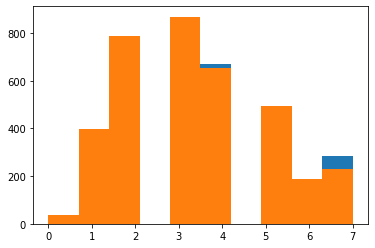

In [56]:
import matplotlib.pyplot as plt
plt.hist(read_df['reads_o'])
plt.hist(read_df['matches_o'])


(array([3.247e+03, 0.000e+00, 3.730e+02, 0.000e+00, 0.000e+00, 3.100e+01,
        0.000e+00, 4.000e+00, 0.000e+00, 2.000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

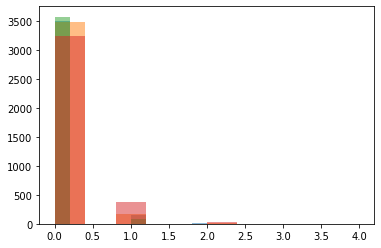

In [57]:
plt.hist(read_df['substitutions_o'], alpha=0.5)
plt.hist(read_df['deletions_o'], alpha=0.5)
plt.hist(read_df['insertions_o'], alpha=0.5)
plt.hist(read_df['error_o'], alpha=0.5)

## Create a training dataset

here we're going to use a VAE to integrate the sequence information with the error 

We have three pieces of information: CIGAR string: 735H92M2I76M1D26M2I10M1D10M2D19M2D59M1D10M1I37M44H
"hat we see is a pattern of integers followed by a single letter, e.g. 69S which is followed by 25M"
https://labs.epi2me.io/notebooks/Introduction_to_SAM_and_BAM_files.html

```
Column	Descripton
1	QNAME	Query name, i.e. the name of the read which was mapped (copied from the read's FASTQ record header)
2	FLAG	An integer which is a short hand way of describing the type of alignment this is. See below for an explanation of FLAGS.
3	RNAME	Name of the reference to which the read was mapped, e.g. chr1
4	POS	1-based leftmost mapping position with respect to reference, e.g. a POS of 100 would indicate the read mapping starts at the 100th position of RNAME
5	MAPQ	An integer which should be a reflection of the quality of the mapping, but for which the scale and meaning may differ by aligner
6	CIGAR	A string of letters and numbers describing the matches and mismatches of the alignment from left to right.
7	RNEXT	Ignore for now. Becomes relevant when working with pair-end data.
8	PNEXT	""
9	TLEN	""
10	SEQ	The sequence of bases constituting the underlying read
11	QUAL	The sequence of ASCII characters encoding the PHRED quality scores for each base of the underlying read
```

```
Operation	Description	Consumes query	Consumes reference
M	alignment match (can be a sequence match or mismatch)	yes	yes
I	insertion to the reference	yes	no
D	deletion from the reference	no	yes
N	skipped region from the reference	no	yes
S	soft clipping (clipped sequences present in SEQ)	yes	no
H	hard clipping (clipped sequences NOT present in SEQ)	no	no
P	padding (silent deletion from padded reference)	no	no
=	sequence match	yes	yes
X	sequence mismatch	yes	yes
```

In [199]:
import math
def chunk_data(x, chunk_size=7): # Use 7 as this means we can relate to eligos2
    # https://stackoverflow.com/questions/13673060/split-string-into-strings-by-length
    chunks, chunk_size = len(x), chunk_size
    return [ x[i:i+chunk_size] for i in range(0, chunks, chunk_size) ]



TTATTTC
[35, 21, 17, 31, 30, 31, 27]


In [234]:
# Chunk the seq and qual
seqs = df['SEQ'].values
kmer_len = 7
chunked_seqs = [chunk_data(x, kmer_len) for x in seqs]
# chunked_seqs = [x for x in chunked_seqs if len(x[0]) == kmer_len]
# print(chunked_seqs[0][0])
# Chunk the errors
qual = df['QUAL'].values
qual_num = []
for q in qual:
    q = q.replace("array('B', ", '').replace(")", "").replace("[", "").replace("]", "")
    try:
        qual_num.append([int(c) for c in q.split(', ')])
    except:
        qual_num.append([])

# print(chunked_qual[0][0])

In [238]:
chunked_qual = [chunk_data(x, kmer_len) for x in qual_num]

## Conv VAE

We're going to use two types of VAEs, 1 a normal VAE for the numeric quality data, 2 a conv VAE for the sequence data. To make the training data for the Conv VAE we want to one hot encode it such that each entry is is the sequence

e.g. our kmer would look like this if it was ATACAAC
```
A|1 0 1 0 1 1 0|
T|0 1 0 0 0 0 0|
G|0 0 0 0 0 0 0|
C|0 0 0 1 0 0 1| 
```
We want to do this with a filter that goes across 2 or more columns at once that we we can capture the spatial information. So we need to one hot encode in a special way (i.e. to make the columns)

In [243]:
def one_hot_gencode(x):
    encoded = np.zeros((4, len(x)))
    for i, n in enumerate(x):
        if n == 'A':
            encoded[0, i] = 1
        elif n == 'T': 
            encoded[1, i] = 1
        elif n == 'G':
            encoded[2, i] = 1
        elif n == 'C':
            encoded[3, i] = 1
    return encoded
print(one_hot_gencode('ATACAAC')) # Yay we get what we wanted above!
# Note the way it is designed, picking up "horizontal lines" would be easy :) 
# Now we need to reshape to store easily and then check we can recover it easily
enc = one_hot_gencode('ATACAAC')
enc = enc.flatten()
print(enc)
enc_vae = enc.reshape((1, 4, 7, 1)) # This is the shape we actually need for the VAE!
enc.reshape((4, 7))

[[1. 0. 1. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1.]]
[1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1.]


array([[1., 0., 1., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1.]])

In [239]:
quals = []
species = df['assembly'].values
genes = df['gene'].values
for i, q in enumerate(chunked_qual):
    for x in q:
        quals.append([species[i], genes[i]] + x)
qual_df = pd.DataFrame(quals)
qual_df.dropna(inplace=True)
qual_df.to_csv(f'../output/quals_species.csv', index=False)
qual_df

,0,1,2,3,4,5,6,7,8
0,Klebsiellapneumoniae-20_GR_12,gltX,2,2.0,5.0,7.0,8.0,12.0,15.0
1,Klebsiellapneumoniae-20_GR_12,gltX,14,14.0,9.0,10.0,11.0,9.0,9.0
2,Klebsiellapneumoniae-20_GR_12,gltX,23,13.0,11.0,11.0,7.0,8.0,10.0
3,Klebsiellapneumoniae-20_GR_12,gltX,12,9.0,17.0,15.0,22.0,25.0,10.0
4,Klebsiellapneumoniae-20_GR_12,gltX,10,4.0,4.0,3.0,4.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...
14053680,Streptococcusmutans-B04Sm5,dnaK,4,6.0,7.0,8.0,18.0,20.0,33.0
14053681,Streptococcusmutans-B04Sm5,dnaK,29,20.0,20.0,12.0,8.0,4.0,4.0
14053682,Streptococcusmutans-B04Sm5,dnaK,6,4.0,7.0,10.0,10.0,10.0,13.0
14053683,Streptococcusmutans-B04Sm5,dnaK,24,29.0,26.0,14.0,19.0,27.0,28.0


In [244]:
seqs = []
species = df['assembly'].values
genes = df['gene'].values
for i, q in enumerate(chunked_seqs):
    for x in q:
        enc = one_hot_gencode(x)
        enc = enc.flatten()
        seqs.append([species[i], genes[i]] + list(enc))
seqs_df = pd.DataFrame(seqs)
seqs_df.dropna(inplace=True) # At some later point keep information about where it came from
seqs_df.to_csv(f'../output/seqs_species.csv', index=False)
seqs_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,Klebsiellapneumoniae-20_GR_12,gltX,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,Klebsiellapneumoniae-20_GR_12,gltX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,Klebsiellapneumoniae-20_GR_12,gltX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,Klebsiellapneumoniae-20_GR_12,gltX,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Klebsiellapneumoniae-20_GR_12,gltX,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14069901,Streptococcusmutans-B04Sm5,dnaK,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14069902,Streptococcusmutans-B04Sm5,dnaK,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
14069903,Streptococcusmutans-B04Sm5,dnaK,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14069904,Streptococcusmutans-B04Sm5,dnaK,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [245]:
subs_seqs_df = seqs_df.head(10000)
subs_seqs_df.to_csv(f'../output/sub_seqs_species.csv', index=False)
subs_qual_df = qual_df.head(10000)
subs_qual_df.to_csv(f'../output/sub_quals_species.csv', index=False)
subs_qual_df

,0,1,2,3,4,5,6,7,8
0,Klebsiellapneumoniae-20_GR_12,gltX,2,2.0,5.0,7.0,8.0,12.0,15.0
1,Klebsiellapneumoniae-20_GR_12,gltX,14,14.0,9.0,10.0,11.0,9.0,9.0
2,Klebsiellapneumoniae-20_GR_12,gltX,23,13.0,11.0,11.0,7.0,8.0,10.0
3,Klebsiellapneumoniae-20_GR_12,gltX,12,9.0,17.0,15.0,22.0,25.0,10.0
4,Klebsiellapneumoniae-20_GR_12,gltX,10,4.0,4.0,3.0,4.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...
10096,Streptococcusmutans-B04Sm5,gltX,22,32.0,31.0,32.0,29.0,23.0,23.0
10097,Streptococcusmutans-B04Sm5,gltX,26,28.0,30.0,34.0,42.0,45.0,41.0
10098,Streptococcusmutans-B04Sm5,gltX,38,44.0,34.0,28.0,32.0,28.0,25.0
10099,Streptococcusmutans-B04Sm5,gltX,29,29.0,26.0,26.0,25.0,26.0,9.0


### Note there is a known issue with eligos2 which causes it not to run
Well documented issue that people post on the git could only get it working on the transcriptome
 
 #256	NZ_CP092052.1	457300	0
NZ_CP092052.1:0-2817030	414624	1
    
NZ_CP092052.1:517-1878
    
 ```
 import sys
# sys.path.append('/media/WorkingSpace/Ariane/output/rnamod/TomboRunner/')
# sys.path.append('/media/WorkingSpace/Ariane/output/rnamod/TomboRunner/ModRunner/')                            
# import pandas as pd
# from ModRunner import EligosRunner
done_runs = []
working_dir = '/media/WorkingSpace/Ariane/output/bacteria/'
output_folder = f'{working_dir}runs/'
runs = os.listdir(f'{output_folder}')
runs = [r for r in runs if 'csv' in r and r not in done_runs]
debug = False
threads = 20
for run in runs:
    if 'ERR3327116' in run:
        run = run.replace('.csv', '')
        data_file = f'{output_folder}{run}.csv'
        logfile = f'{output_folder}{run}_logfile.txt'
        wt_sample = run
        # 1. Setup transcriptome and bam files with minimap2
        #runner = Minimap2Runner(data_file, debug=debug, logging_file=logfile)
        #runner.gff_to_bed(filter_value=None)
        #runner.genome_to_transcripts()
        #print(run, runner.get_reference_path(run))
        #runner.fasta_to_bam()
    #     runner.fasta_to_bam(genome=True) # Do this for eligos2 later on (skip if not doing eligos2)
        #runner.gff_to_bed(filter_value='gene')
        # 5. Eligos2 NO IVT comparison for WT only
        runner = EligosRunner(data_file, debug=debug, logging_file=logfile)
        runner.test_against_model_ts(wt_sample)


 ```

In [106]:
' '.join(['/media/ArchivedDatasets/RNAMOD/scripts/eligos2/./eligos2', 'rna_mod', '-t', '40', '-i', '/media/WorkingSpace/Ariane/output/bacteria/runs/SRR12090427.sorted.bam', '-ref', '/media/WorkingSpace/Ariane/output/bacteria/genomes/GCF_0222269951_ASM2222699v1_genomic_transcripts.fasta', '-p', '/media/WorkingSpace/Ariane/output/bacteria/runs//eligos2_SRR12090427_vs_m6A_ts.txt', '-reg', '/media/WorkingSpace/Ariane/output/bacteria/runs/SRR12090427.bed', '-o', '/media/WorkingSpace/Ariane/output/bacteria/runs/'])

'/media/ArchivedDatasets/RNAMOD/scripts/eligos2/./eligos2 rna_mod -t 40 -i /media/WorkingSpace/Ariane/output/bacteria/runs/SRR12090427.sorted.bam -ref /media/WorkingSpace/Ariane/output/bacteria/genomes/GCF_0222269951_ASM2222699v1_genomic_transcripts.fasta -p /media/WorkingSpace/Ariane/output/bacteria/runs//eligos2_SRR12090427_vs_m6A_ts.txt -reg /media/WorkingSpace/Ariane/output/bacteria/runs/SRR12090427.bed -o /media/WorkingSpace/Ariane/output/bacteria/runs/'

### Now we want to align each gene that appears in all our references

To do this, let's get: http://www.clustal.org/omega/ this will also help us if we're trying to map between RNA modifications.

```
wget http://www.clustal.org/omega/clustalo-1.2.4-Ubuntu-x86_64
chmod u+x clustalo-1.2.4-Ubuntu-x86_64
```


clustalo-1.2.4-Ubuntu-x86_64 -i my-in-seqs.fa -o my-out-seqs.fa -v


In [137]:
genes = ['gltX', 'pheT', 'rpoC', 'dnaK']
for gene in genes:
    print(f'/media/WorkingSpace/Ariane/output/bacteria/software/./clustalo-1.2.4-Ubuntu-x86_64 -i ../output/{gene}-ref.fasta -o ../output/{gene}-ref_msa.fasta -v')

/media/WorkingSpace/Ariane/output/bacteria/software/./clustalo-1.2.4-Ubuntu-x86_64 -i ../output/gltX-ref.fasta -o ../output/gltX-ref_msa.fasta -v
/media/WorkingSpace/Ariane/output/bacteria/software/./clustalo-1.2.4-Ubuntu-x86_64 -i ../output/pheT-ref.fasta -o ../output/pheT-ref_msa.fasta -v
/media/WorkingSpace/Ariane/output/bacteria/software/./clustalo-1.2.4-Ubuntu-x86_64 -i ../output/rpoC-ref.fasta -o ../output/rpoC-ref_msa.fasta -v
/media/WorkingSpace/Ariane/output/bacteria/software/./clustalo-1.2.4-Ubuntu-x86_64 -i ../output/dnaK-ref.fasta -o ../output/dnaK-ref_msa.fasta -v


## Finally run fast tree


Download fasttree: http://www.microbesonline.org/fasttree/FastTree


```
wget http://www.microbesonline.org/fasttree/FastTree
chmod u+x FastTree
```

FastTree needs an alignment file, `FastTree -gtr -nt alignment_file > tree_file ` so let's make one just using the 
genes that are shared, since we're going to be looking at the shared RNA modifications on just the genes anyway.

In [135]:
genes = ['gltX', 'pheT', 'rpoC', 'dnaK']
for gene in genes:
    os.system(f'/media/WorkingSpace/Ariane/output/bacteria/software/./FastTree -gtr -nt ../output/{gene}-ref_msa.fasta > ../output/{gene}-ref_tree.nwk')

## Use ete3 to visualise the tree

Go to the visualisation notebook!